In [82]:
import xarray as xr
import rioxarray
import geopandas as gpd
from landlab.grid import RasterModelGrid
from landlab.components import OverlandFlow, SinkFiller, GroundwaterDupuitPercolator
from landlab.components import CRESTHH, map_gauge_loc_to_node
from landlab.components import CREST
import matplotlib.pyplot as plt
from landlab.io import read_geotif
from landlab.grid.mappers import map_mean_of_link_nodes_to_link

In [2]:
basin_shp= gpd.read_file('/Users/allen/OneDrive - University of Oklahoma/CRESTHH/subbasins/08076700.shp',
                         crs='EPSG:4326')
basin_shp= basin_shp.set_crs('EPSG:4326')
basin_shp= basin_shp.to_crs('EPSG:32215')

In [3]:
dem_region= rioxarray.open_rasterio('/Users/allen/OneDrive - University of Oklahoma/CRESTHH/Case study - Harvey/CRM_Houston_NAm83/DEM_100m.tif')
# dem_region= rioxarray.open_rasterio('/Users/allen/OneDrive - University of Oklahoma/CRESTHH/Case study - Harvey/demHouston033s_NAm83.tif/demHouston033s_NAm83.tif')
dem_region= dem_region.rio.write_crs('EPSG:4326')
dem_region= dem_region.rio.reproject('EPSG:32215')
basin_dem= dem_region.rio.clip(basin_shp.geometry, basin_shp.crs).squeeze().sortby('y', ascending=True)

basin= RasterModelGrid(shape= basin_dem.squeeze().shape,
                       xy_spacing=np.diff(basin_dem.x.values)[0],
                       xy_of_lower_left= [basin_dem.x.values[0], basin_dem.y.values[0]]
                      )
basin.axis_units = ('m', 'm')

## Initialize

In [7]:
z= basin.add_field('topographic__elevation', basin_dem.values.astype(float),
                   at="node", clobber=True, dtype=float)
# aquifer depth 30 meters
_= basin.add_field('aquifer_base__elevation', basin_dem.values.astype(float)-30,
                   at="node", clobber=True, dtype=float)

_= basin.add_field('surface_water__stage', basin_dem.values.astype(float), 
                   at='node', clobber=True, dtype=float)
# one soil bucket (vadose zone)
_= basin.add_field('soil_moisture__stage', basin_dem.values.astype(float),
                   at='node', clobber=True, dtype=float)
# suppose zero groundwater level
_= basin.add_field('ground_water__stage', basin_dem.values.astype(float)-30,
                   at='node', clobber=True, dtype=float)

_= basin.add_ones('manning_n__param',
                   at='link', clobber=True, dtype=float)

basin.at_link['manning_n__param'][:]*=0.3

_= basin.add_zeros('surface_water__discharge', at='link', clobber=True, dtype=float)
_= basin.add_zeros('surface_water__depth', at='link', clobber=True, dtype=float)
_= basin.add_zeros('infiltration', at='link', clobber=True, dtype=float)

System of equations

States:
1. surface water
2. soil moisture
3. ground water
4. river stage

Fluxes:
1. river flow
2. overland flow
3. interflow
4. base flow

$Y_{t+1}=f_t*dt+Y_t$

In [20]:
from landlab.components.overland_flow import _links

In [21]:
basin.number_of_nodes

124200

In [22]:
basin.at_node['surface_water__stage'][basin.number_of_nodes//2-10:basin.number_of_nodes//2+10]+= 0.2

In [81]:
dir(basin)

['BAD_INDEX',
 'BC_LINK_IS_ACTIVE',
 'BC_LINK_IS_FIXED',
 'BC_LINK_IS_INACTIVE',
 'BC_NODE_IS_CLOSED',
 'BC_NODE_IS_CORE',
 'BC_NODE_IS_FIXED_GRADIENT',
 'BC_NODE_IS_FIXED_VALUE',
 'BC_NODE_IS_LOOPED',
 'VALID_LOCATIONS',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_variable',
 '_all_node_azimuths_map',
 '_all_node_distances_map',
 '_axis_name',
 '_axis_units',
 '_calc_active_face_flux_divergence_at_cell',
 '_calc_active_face_flux_divergence_at_node',
 '_calc_active_link_flux_divergence_at_node',
 '_calc_face_flux_divergence_at_cell',
 '_calc_net_active_face_flux_at_cell',
 '_calc_net_active_face_flux_at_node',

In [69]:
def flux(P, ET, grid, gdp, dt):
    
    WM= grid['node']['WM_param']
    B= grid['node']['B_param']
    SM= grid['node']['soil_moisture__content']    

    # Calculate surface flux
    grid.at_link['topographic__elevation']= grid.map_max_of_link_nodes_to_link('topographic__elevation')
    grid.at_link['surface_water__stage']= grid.map_max_of_link_nodes_to_link('surface_water__stage')
    grid.at_link['surface_water__depth']= grid['link']['surface_water__stage'] -\
                                            grid['link']['topographic__elevation']
    s0= grid.add_zeros('surface_water__slope', at='link', clobber=True)
    s0= grid.calc_grad_at_link('surface_water__stage', out=s0)
    
    _q= grid.dx / grid.at_link['manning_n__param']* grid.at_link['surface_water__depth']**(5/3)*\
        s0**0.5
    Q= grid.map_sum_of_outlinks_to_node(_q)
    precipSoil= grid['node']['surface_water__depth']
    Wmaxm= WM* (1+B)
    A = Wmaxm * (1-(1.0-SM/Wmaxm)**(1.0/(1.0+B)))
    infiltration=WM*((1-A/Wmaxm)**(1+B)-(1-(A+precipSoil)/Wmaxm)**(1+B))
    infiltration[infiltration>precipSoil]= precipSoil[infiltration>precipSoil]
    rhs1= P-ET-Q-infiltration/dt
    
#   Calculate unsaturated zone flux
    unsaturatedThickness= grid.node['topographic__elevation'] - grid.node['ground_water__stage']
    groundWaterDepth= grid.node['ground_water__stage'] - grid.node['aquifer_base__elevation']
    recharge= (infiltration+unsaturatedThickness)/WM/2*grid.node['Ksat_param']
    rhs2= infiltration/dt-recharge/dt-E_sm
    
#   Calculate groundwater flux
    gdp.recharge= recharge/dt
    gdp.run_one_step(dt)
    rhs3= gdp['node']['surface_water__specific_discharge']
    
    return rhs
    


In [78]:
_= basin.add_zeros('soil_moisture__content', at='node', clobber=True)
_= basin.add_ones('WM_param', at='node',clobber=True)
basin['node']['WM_param']*=300
_= basin.add_ones('B_param', at='node', clobber=True)
_= basin.add_ones('')

In [48]:
basin.status_at_node[np.isclose(z, basin_dem._FillValue)] = basin.BC_NODE_IS_CLOSED

In [46]:
from landlab import imshow_grid_at_node

In [60]:
(basin['node']['surface_water__stage'] - basin['node']['topographic__elevation']).max()

0.2000000000007276

/Users/allen/Documents/Python/landlab/landlab/plot/imshow.py:267: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("terrain"))
  cmap.set_bad(color=color_for_closed)
/Users/allen/Documents/Python/landlab/landlab/plot/imshow.py:307: MatplotlibDeprecationWarning: The 'norm' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cb = plt.colorbar(norm=norm, shrink=shrink)


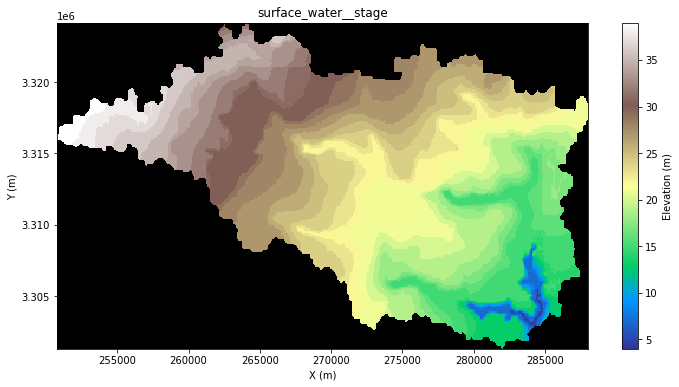

In [59]:
fig= plt.figure(figsize=(12,6))
basin
imshow_grid_at_node(basin, 'surface_water__stage', colorbar_label='Elevation (m)', cmap='terrain')
plt.show();

In [18]:
def CREST(precipIn, overland, petIn, SM, Ksat,
        WM, B, IM, KE,
        timestep):

    stepHour= timestep/3600.
    precip= precipIn * timestep*1000.#Input is m/s, convert to mm
    pet= petIn * timestep*1000. #mm
    adjPET= pet * KE
    SM*=1000 # mm
    #print 'soil moisture', SM
    #print 'rain', precip
    #print 'evaporation:', pet

    #SS0+= RS*timestep
    #SI0+= RI*timestep
    # zero division protection
    if WM<0: WM=100
    if SM<0: SM=0
    if IM<0: IM=0
    elif IM>1.0: IM=1.0
    if B<0.0: B=1.0
    if Ksat<0.0: Ksat=1.0

    precip+= overland* 1000. # combine precipitation and surface runoff

    if precip>adjPET:
        #available precipitation in soil
        precipSoil= (precip-adjPET) * (1-IM)

        precipImperv = precip -adjPET - precipSoil

        interflowExcess = SM - WM

        if interflowExcess< 0.0:
            interflowExcess= 0.0

        if SM>WM: SM= WM

        if SM<WM:

            Wmaxm=WM*(1+B)
            A = Wmaxm * (1-(1.0-SM/WM)**(1.0/(1.0+B)))

            if precipSoil + A >=Wmaxm:
                R= precipSoil-(WM-SM)
                if R<0: R=0.0
                Wo=WM
            else:
                infiltration=WM*((1-A/Wmaxm)**(1+B)-(1-(A+precipSoil)/Wmaxm)**(1+B))
                if infiltration>precipSoil:
                    infiltration= precipSoil
                R = precipSoil - infiltration
                if R<0: R=0.0
                Wo= SM+infiltration
        else:
            R= precipSoil
            Wo= WM


        temX= (SM+Wo)/WM/2*Ksat*stepHour

        if R<=temX:
            interflow= R
        else:
            interflow= temX

        overland= R- interflow + precipImperv

        actET= adjPET

        interflow+= interflowExcess
    else:
        overland=0.0
        interflowExcess= SM -WM

        if interflowExcess<0.0:
            interflowExcess= 0.0
        interflow= interflowExcess
        if SM>WM:
            SM= WM

        ExcessET= (adjPET - precip)*SM/WM

        if ExcessET<SM:
            Wo= SM-ExcessET
        else:
            Wo= 0.0
            ExcessET= SM

        actET = ExcessET + precip

    SM= Wo
    balanced= checkWaterBalance(precip, actET, SM, overland, interflow)
    assert balanced==1, 'overland: %.1f precip: %.1f evapo: %.1f Water balance violated!'%(overland, precip, actET)

    #convert back to m or m/s
    overland= overland/1000.
    interflow= interflow/1000.
    SM= SM/1000.
    actET/=(1000.)

    #print 'overland flow:', overland
    #print 'soil moisture: ',SM

    return SM, overland, infiltration, recharge, actET

In [10]:
CREST()

In [13]:
basin.__dict__

{'_xy_of_lower_left': (250788.29760366568, 3301337.7818065467),
 '_shape': (276, 450),
 '_ds': <xarray.Dataset>
 Dimensions:         (Two: 2, cell: 122752, face: 246226, link: 247674, max_patch_links: 4, node: 124200, patch: 123475)
 Coordinates:
   * node            (node) int64 0 1 2 3 4 ... 124196 124197 124198 124199
 Dimensions without coordinates: Two, cell, face, link, max_patch_links, patch
 Data variables:
     mesh            <U1 'a'
     y_of_node       (node) float64 3.301e+06 3.301e+06 ... 3.324e+06 3.324e+06
     x_of_node       (node) float64 2.508e+05 2.509e+05 ... 2.879e+05 2.88e+05
     nodes_at_link   (link, Two) int64 0 1 1 2 2 ... 124197 124198 124198 124199
     links_at_patch  (patch, max_patch_links) int64 450 899 449 ... 247223 246774
     node_at_cell    (cell) int64 451 452 453 454 ... 123745 123746 123747 123748
     nodes_at_face   (face, Two) int64 1 451 2 452 ... 124197 123748 124198,
 '_frozen': True,
 '_origin': (3301337.7818065467, 250788.29760366568),